# **Missing Values, Outliers, and Correlations**

### Lucía Poyan, Nuria Olmedilla y Claudia Gemeno

In this notebook, we study and preprocess numerical and categorical variables. The following steps will be performed:


### **Steps:**

1. Change Variable Types:  
   - Ensure variables have the correct data types (e.g., categorical, numerical).

2. Split into Train and Test:  
   - Divide the dataset into training and test sets to ensure proper evaluation and prevent data leakage.

3. Variable Analysis with Descriptive Graphs:  
   - Explore each variable using histograms, boxplots, and bar charts for a comprehensive understanding of distributions and outliers.

4. Numerical Variables:  
   - Pearson Correlations: Analyze the relationships between numerical variables.
   - Outlier Analysis: Identify and handle outliers using techniques like the interquartile range (IQR).
   - Missing Values: Assess and impute missing values using appropriate methods (mean, median, or regression).

5. Categorical Variables:  
   - Missing Value Imputation: Fill missing values using the mode or other contextual methods.
   - Cramér's V Correlation Analysis: Study the associations between categorical variables and the target variable.


## **Import Libraries**

To preprocess the dataset and analyze missing values, outliers, and correlations, the following libraries will be imported:




In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## **Functions**

To keep the code organized and reusable, we store frequently used automated functions in an `auxiliary_functions.py` file and import them into our project. This approach promotes code reuse and keeps the main script clean.


In [2]:
functions_code = """

def plot_continuous_variable(df, col_name, target=None):
    \"\"\"
    Plot continuous variables, with or without the target variable.

    Parameters:
    - df: pd.DataFrame
    DataFrame containing the data.
    - col_name: str
    Name of the column to visualize.
    - target: str, optional
    Target variable for facets (default is None).
    \"\"\"

    count_null = df[col_name].isnull().sum()  # Count the null values in a specific column

    fig, axes = plt.subplots(1, 2 if target else 1, figsize=(14, 5), dpi=90)  # Create subplots

    # Plot a histogram with KDE (Kernel Density Estimation) for the continuous variable
    sns.histplot(df[col_name].dropna(), kde=True, ax=axes[0] if target else axes, color="skyblue")
    axes[0 if target else 0].set_title(f"{col_name} (nulls: {count_null})")
    axes[0 if target else 0].set_xlabel(col_name)
    axes[0 if target else 0].set_ylabel("Count")

    if target:  # If a target variable is provided, we plot a boxplot
        sns.boxplot(x=target, y=col_name, data=df, ax=axes[1], palette="Set2")
        axes[1].set_title(f"{col_name} by {target}")
        axes[1].set_ylabel(col_name)
        axes[1].set_xlabel(target)

    plt.tight_layout()  # Adjust the spacing
    plt.show()  # Display the plot



def plot_categorical_variable(df, col_name, target=None):
    \"\"\"
    Plot categorical variables, with or without the target variable.

    Parameters:
    - df: pd.DataFrame
        DataFrame containing the data.
    - col_name: str
        Name of the column to visualize.
    - target: str, optional
        Target variable for facets (default is None).
    \"\"\"

    count_null = df[col_name].isnull().sum()  # Count the null values in the column

    # Handle too many categories (limit to the 10 most frequent)
    unique_vals = df[col_name].astype(str).value_counts()  # Count the unique values
    if len(unique_vals) > 10:  # If there are more than 10 categories, we limit to the top 10
        top_vals = unique_vals.head(10).index
        df = df[df[col_name].astype(str).isin(top_vals)]

    fig, axes = plt.subplots(1, 2 if target else 1, figsize=(14, 5), dpi=90)  # Create subplots

    # Plot a countplot for the categorical variable
    sns.countplot(
        x=df[col_name].astype(str),
        order=sorted(df[col_name].astype(str).unique()),
        ax=axes[0] if target else axes,
        color="skyblue"
    )
    axes[0 if target else 0].set_title(f"{col_name} (nulls: {count_null})")
    axes[0 if target else 0].set_xlabel(col_name)
    axes[0 if target else 0].set_ylabel("Count")
    axes[0 if target else 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    if target:  #If a target variable is provided, we plot the proportions of each class
        proportions = (
            df.groupby(col_name)[target]  # Group by the categorical variable
            .value_counts(normalize=True)  # Plot a countplot for the categorical variable
            .rename("proportion")
            .reset_index()
        )
        sns.barplot(
            x=col_name,
            y="proportion",
            hue=target,
            data=proportions,
            ax=axes[1],
            palette="Set2"
        )
        axes[1].set_title(f"Proportions of {target} by {col_name}")
        axes[1].set_xlabel(col_name)
        axes[1].set_ylabel("Proportion")
        axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()  # Adjust the spacing
    plt.show()  # Display the plot



def plot_feature_variable(df, col_name, isContinuous, target=None):
    \"\"\"
    Decide which plotting function to call based on the variable type (continuous or categorical).

    Parameters:
    - df: pd.DataFrame
        DataFrame containing the data.
    - col_name: str
        Name of the column to visualize.
    - isContinuous: bool
        Whether the variable is continuous or categorical.
    - target: str, optional
        Target variable for facets (default is None).
    \"\"\"

    if isContinuous:
        plot_continuous_variable(df, col_name, target=target)  # If it is continuous, call the function for continuous variables
    else:
        plot_categorical_variable(df, col_name, target=target)  # If it is categorical, call the function for categorical variables



def analyze_outliers(credit_processed, list_var_num, target, multiplier=3):
    \"\"\"
    Analyze the outliers for numerical variables and return the results.
    - df: DataFrame
    - list_var_num: list of numerical variables to analyze
    - target: target variable for analysis
    - multiplier: factor to detect outliers (default is 3 times the IQR)
    \"\"\"

    outliers = []
    for col in list_var_num:
        q1 = credit_processed[col].quantile(0.25)
        q3 = credit_processed[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        # Identify the outliers in the column
        outliers_in_col = credit_processed[(credit_processed[col] < lower_bound) | (credit_processed[col] > upper_bound)]
        outliers.append((col, len(outliers_in_col)))

    # Create a DataFrame with the outlier results
    outlier_df = pd.DataFrame(outliers, columns=["Variable", "Outlier Count"])
    return outlier_df



def treat_outliers(credit_processed, list_var_num, multiplier=3, method="median"):
    \"\"\"
    Handle the outliers in numerical variables by replacing them with the mean or median.

    - df: DataFrame
    - list_var_num: list of numerical variables to treat
    - multiplier: factor to detect outliers (default is 3 times the IQR)
    - method: 'median' or 'mean' to indicate which method to use for replacing the outliers
    \"\"\"

    for col in list_var_num:
        q1 = credit_processed[col].quantile(0.25)
        q3 = credit_processed[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        outliers_in_col = (credit_processed[col] < lower_bound) | (credit_processed[col] > upper_bound)

        if method == "median":
            median_value = credit_processed[col].median()
            credit_processed[col] = credit_processed[col].where(~outliers_in_col, median_value)

        elif method == "mean":
            mean_value = credit_processed[col].mean()
            credit_processed[col] = credit_processed[col].where(~outliers_in_col, mean_value)

    return credit_processed



def analyze_nulls(df):
    \"\"\"
    Analyze the null values in a DataFrame, both by columns and by rows.

    - df: DataFrame to analyze.
    \"\"\"


    nulls_columns = df.isnull().sum()
    percentage_nulls_columns = (nulls_columns / len(df) * 100).round(2)

    pd_null_columns = pd.DataFrame({
        'nulls_columns': nulls_columns,
        'percentage (%)': percentage_nulls_columns
    }).sort_values(by='nulls_columns', ascending=False)

    nulls_rows = df.isnull().sum(axis=1)
    percentage_nulls_rows = (nulls_rows / df.shape[1] * 100).round(2)

    pd_null_rows = pd.DataFrame({
        'nulls_rows': nulls_rows,
        'percentage (%)': percentage_nulls_rows
    }).sort_values(by='nulls_rows', ascending=False)

    return pd_null_columns, pd_null_rows



def calculate_nulls_by_objective(df, target_col, type_variable):
    \"\"\"
    Calculate the percentage of null values per column, grouped by the target variable (TARGET).

    - df: DataFrame containing the data.
    - target_col: Name of the target column (TARGET).
    - type_variable: 'categorical' or 'continuous' to select the type of variables to analyze.
    \"\"\"


    if type_variable == 'categorical':
        columns = list_var_cat
    elif type_variable == 'continuous':
        columns = list_var_continuous
    else:
        raise ValueError("The type_variable must be 'categorical' or 'continuous'.")

    columns = [col for col in columns if col in df.columns]

    nulls_by_objective = pd.DataFrame(index=columns)

    grouped = df.groupby(target_col)
    for target_value, group in grouped:
        nulls_by_objective[f"Target_{int(target_value)}"] = (
            group[columns].isnull().sum() / len(group) * 100
        ).round(2)

    nulls_by_objective["Total_Percentage (%)"] = nulls_by_objective.mean(axis=1).round(2)

    if "Target_1" in nulls_by_objective.columns and "Target_0" in nulls_by_objective.columns:
        nulls_by_objective["Difference_0_1 (%)"] = (
            nulls_by_objective["Target_1"] - nulls_by_objective["Target_0"]
        ).round(2)

    return nulls_by_objective.sort_values(by="Total_Percentage (%)", ascending=False)



def get_corr_matrix(dataset, method='pearson', size_figure=[10, 8]):

    \"\"\"
    Create a correlation matrix for the numerical variables in the dataset and visualize it.

    - dataset: DataFrame containing the data.
    - method: The correlation method, default is 'pearson'.
    - size_figure: Figure size, default is [10, 8].
    \"\"\"


    if dataset is None:
        print('Arguments are missing for the function')
        return None
    corr = dataset.corr(method=method)
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    plt.figure(figsize=size_figure)
    sns.heatmap(corr, center=0, square=True, linewidths=.5, cmap='viridis')
    plt.show()
    return corr



def cramers_v(confusion_matrix):
    \"\"\"
    Calculate the value of Cramér's V, a measure of association between two categorical variables.

    - confusion_matrix: contingency matrix (frequency table) between two categorical variables.
    \"\"\"


    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

"""

with open("auxiliary_functions.py", "w") as file:
    file.write(functions_code)

## **Reading Data from Initial Preprocessing**

Reading the data and changing the variable types




In [3]:
credit_processed = pd.read_csv(r'../content/pd_data_initial_preprocessed.csv')
credit_processed

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002.0,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,3,10.0,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003.0,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765.0,-1188.0,-1186.0,-291.0,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,1,11.0,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,1,9.0,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
credit_processed.shape

(307511, 122)

In [5]:
credit_processed.columns

Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_annuity',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=122)

## **Restructuring Variables Based on Their Data Types and Information**

We will proceed to restructure the variables by classifying them again based on their data type and the information they contain, dividing them into categorical and continuous variables, similar to how we did in the previous analysis.

To do this, we will calculate the number of unique values for each variable in the dataset. This procedure will give us a general idea of which variables could be categorical and which ones numeric. After the calculations, we have set a threshold of 50 unique values, as the dataset contains a considerable number of rows, and we consider this value to be appropriate for the initial distinction. This threshold can be adjusted later as we progress in the analysis.

In practical terms, those variables with fewer than 50 unique values will be considered categorical variables, while those with more than 50 unique values will be classified as numeric. This is based on the premise that, generally, categorical variables tend to have a limited number of distinct values, while numeric variables often have a wider diversity of values.

Upon reviewing the variables we initially classified as categorical, we realized that some of them, despite having fewer than 50 unique values, are actually numeric variables. One example is the variable `obs_30_cnt_social_circle`, which contains only 33 unique values, but represents the number of observable social circle observations of the customer with a 30-day delinquency (DPD), clearly indicating that it should be treated as a numeric variable.

Based on this analysis, we have decided to reconsider the classification of this and other similar variables, changing them to numeric, as their nature and context suggest they should be treated as such, regardless of the number of unique values they have.


In [6]:
dict_nunique = {col: credit_processed[col].nunique() for col in credit_processed.columns}
filtrado_dict = {key: value for key, value in dict_nunique.items() if value < 50}

list_var_cat = list(filtrado_dict.keys())
list_var_continuous = [col for col in credit_processed.select_dtypes(include='number').columns if col not in list_var_cat]

manual_numeric_vars = [
    'amt_req_credit_bureau_hour',
    'amt_req_credit_bureau_day',
    'amt_req_credit_bureau_week',
    'amt_req_credit_bureau_mon',
    'amt_req_credit_bureau_qrt',
    'amt_req_credit_bureau_year',
    'obs_30_cnt_social_circle',
    'def_30_cnt_social_circle',
    'obs_60_cnt_social_circle',
    'def_60_cnt_social_circle',
    'elevators_mode',
    'entrances_mode',
    'floorsmax_mode',
    'floorsmin_mode',
    'elevators_medi',
    'entrances_medi',
    'floorsmax_medi',
    'floorsmin_medi',
    'hour_appr_process_start',
    'cnt_fam_members',
    'cnt_children',
    'nonlivingapartments_mode',
    'own_car_age',

]

list_var_cat = [col for col in list_var_cat if col not in manual_numeric_vars]
list_var_continuous += manual_numeric_vars


print("Categorical variables:", list_var_cat)
print("Numerical variables:", list_var_continuous)

Categorical variables: ['target', 'name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'occupation_type', 'region_rating_client', 'region_rating_client_w_city', 'weekday_appr_process_start', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'fondkapremont_mode', 'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode', 'flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6', 'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 'flag_document_12', 'flag_document_13', 'flag_document_14', 'flag_document_15', 'flag_document_16', 'flag_document_17', 'flag_document_18',

In [9]:
credit_processed[list_var_cat] = credit_processed[list_var_cat].astype("category")
credit_processed[list_var_continuous] = credit_processed[list_var_continuous].astype(float)
credit_processed.dtypes.head(20)

,0
sk_id_curr,float64
target,category
name_contract_type,category
code_gender,category
flag_own_car,category
flag_own_realty,category
cnt_children,float64
amt_income_total,float64
amt_credit,float64
amt_annuity,float64


## **Stratified Train-Test Split**

We will split the dataset into training and test sets, ensuring that the distribution of the target variable is preserved in both sets.

Before proceeding with the train-test split, let's visualize a bar chart that shows the percentage distribution and count of the `target` variable in the dataset. To do this, we will first calculate the percentage and count of each value in the `target` variable, combine them into a single DataFrame, and then use Plotly to generate a histogram that clearly visualizes these values.

### Steps:
1. **Calculate the percentage and count** of each value in the `target` variable.
2. **Combine the results** into a single DataFrame.
3. **Use Plotly** to generate a histogram that displays the distribution of the `target` variable.

In [10]:
pd_plot_target = credit_processed['target'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
pd_plot_target.rename(columns={'index': 'target'}, inplace=True)

pd_plot_target_count = credit_processed['target'].value_counts().rename('count').reset_index()
pd_plot_target_count.rename(columns={'index': 'target'}, inplace=True)

pd_plot_target_pc = pd.merge(pd_plot_target, pd_plot_target_count, on=['target'], how='inner')

fig = px.histogram(pd_plot_target_pc, x="target", y="percent")

fig.update_layout(
    bargap=0.2)

fig.show()

The graph obtained shows the distribution of the `target` variable in percentage terms within a data set.

Most of the data is concentrated in a single value of the `target` variable (0), which represents more than 90% of the total. The value 1 has a much smaller representation, with less than 10%.

This imbalance indicates that the `target` variable has a very unequal proportion, which is a common challenge in binary classification problems.

Models trained on this data set could be biased towards the majority class (0), ignoring the minority (1).


Next, we will prepare the data to train the model by splitting it into two sets: one for training (80%) and one for testing (20%).
The split is done in a stratified manner, ensuring that the distribution of the target variable (target) is similar in both sets. This is crucial to ensure that the model is trained and evaluated with balanced representations of the classes. Finally, we will combine the features with the target variable in both sets and print the class distribution in each to verify the correct representation.

In [11]:
X = credit_processed.drop('target', axis=1)
y = credit_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [12]:
credit_processed_train = pd.concat([X_train, y_train], axis=1)
credit_processed_test = pd.concat([X_test, y_test], axis=1)

print('== Distribution in the training set ==')
print(credit_processed_train['target'].value_counts(normalize=True))

print('== Distribution in the test set ==')
print(credit_processed_test['target'].value_counts(normalize=True))

== Distribution in the training set ==
target
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Distribution in the test set ==
target
0    0.919272
1    0.080728
Name: proportion, dtype: float64


## **Descriptive Visualization of the Data**

We visualize the number of null values by rows and by columns.


In [15]:
pd_null_columns, pd_null_rows = analyze_nulls(credit_processed_train)

In [16]:
print(pd_null_columns['nulls_columns'].shape, pd_null_rows['nulls_rows'].shape)

(122,) (246008,)


In [20]:
pd_null_columns.head()

,nulls_columns,percentage (%)
commonarea_mode,171973,69.91
commonarea_avg,171973,69.91
commonarea_medi,171973,69.91
nonlivingapartments_medi,170874,69.46
nonlivingapartments_avg,170874,69.46


In [21]:
pd_null_rows.head()

,nulls_rows,percentage (%)
197736,61,50.0
269786,61,50.0
269492,61,50.0
150206,61,50.0
244833,61,50.0


## **Distribution of the Remaining Variables**

We visualize the distribution of the other variables in the dataset.



<ipython-input-23-ab79502d12a2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




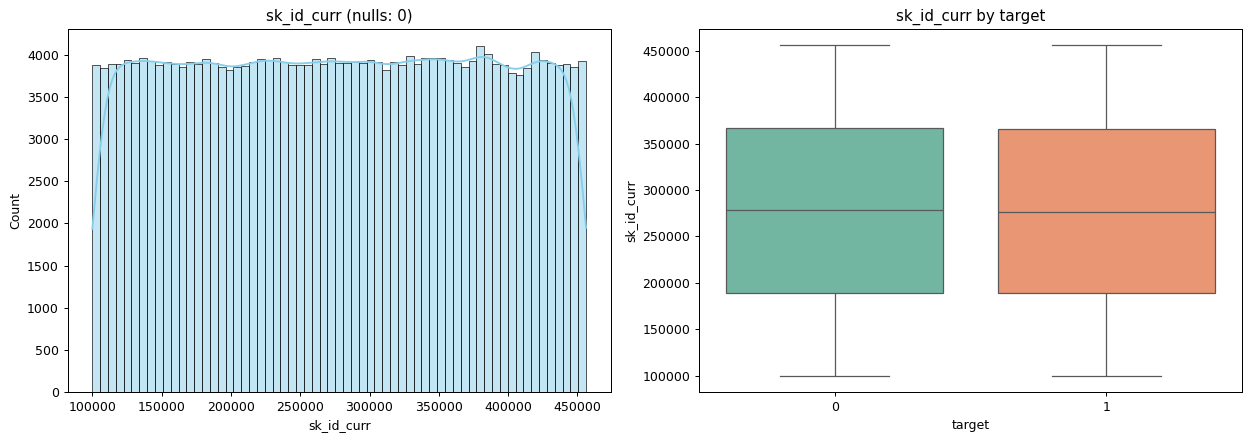

<ipython-input-23-ab79502d12a2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




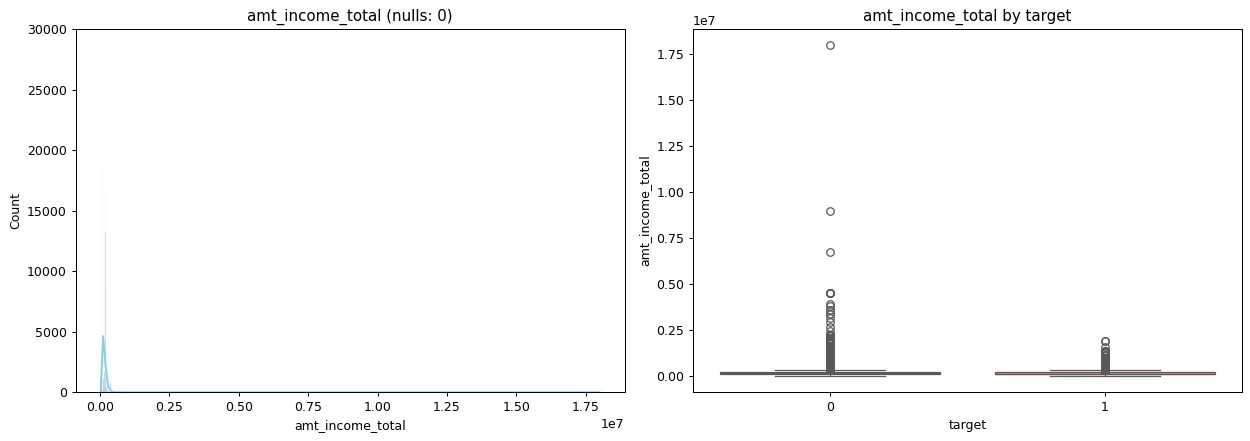

<ipython-input-23-ab79502d12a2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




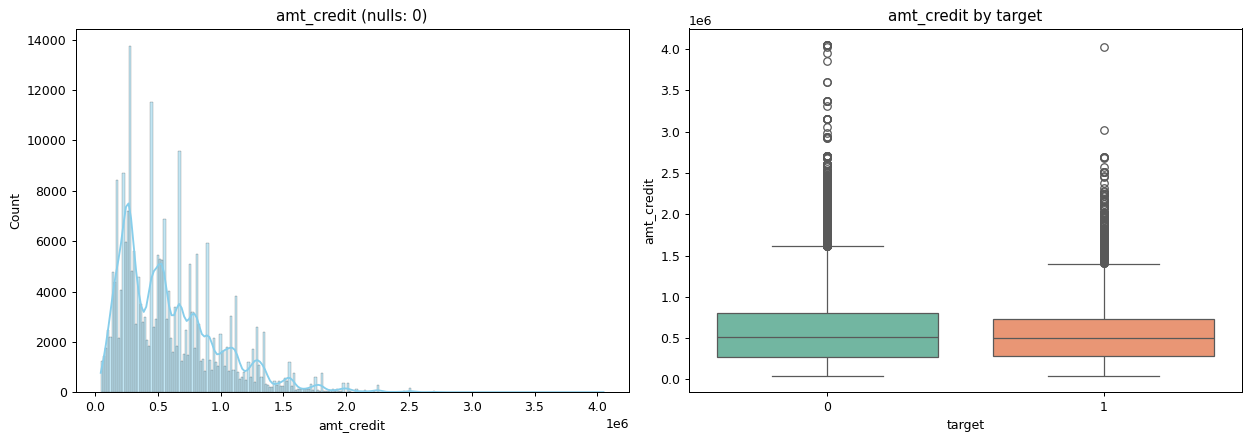

<ipython-input-23-ab79502d12a2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




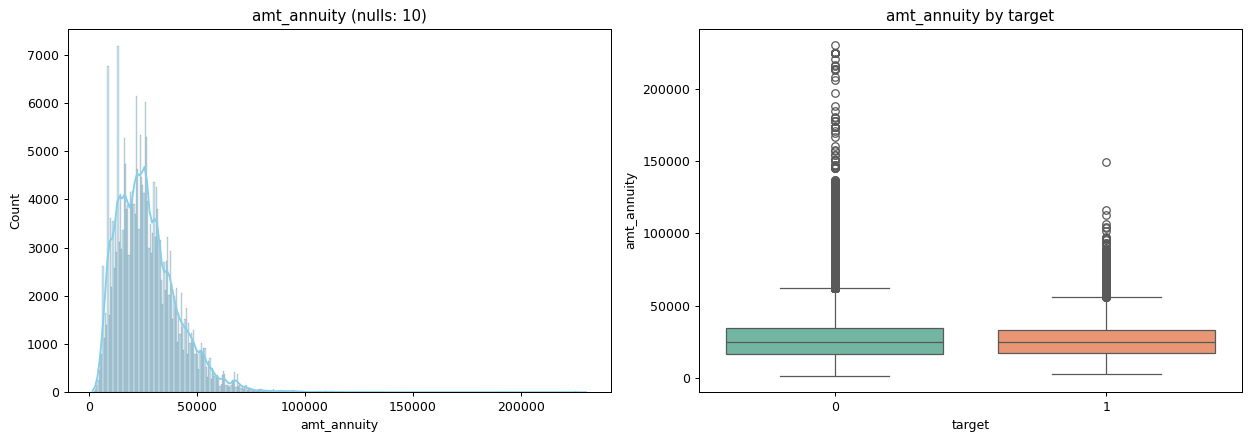

<ipython-input-23-ab79502d12a2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




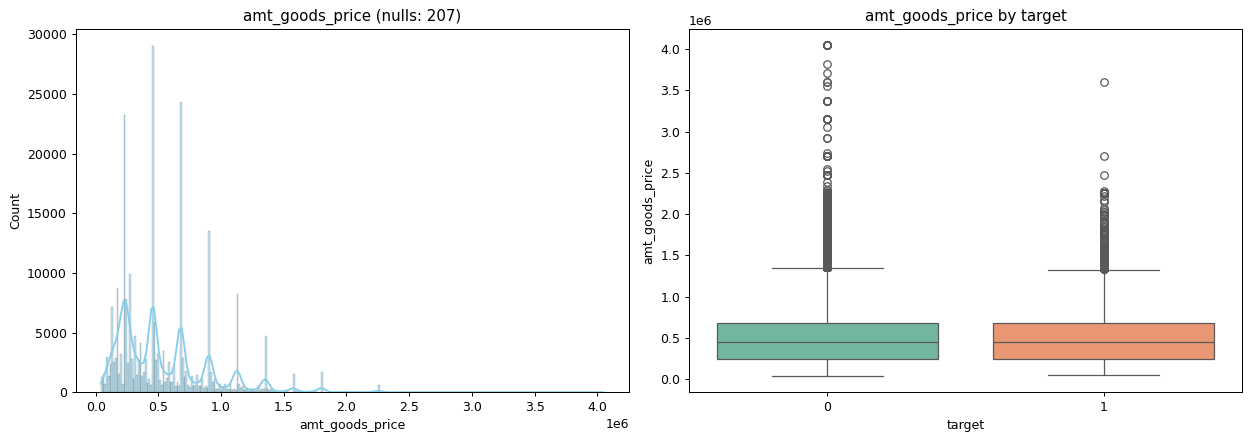

<ipython-input-23-ab79502d12a2>:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



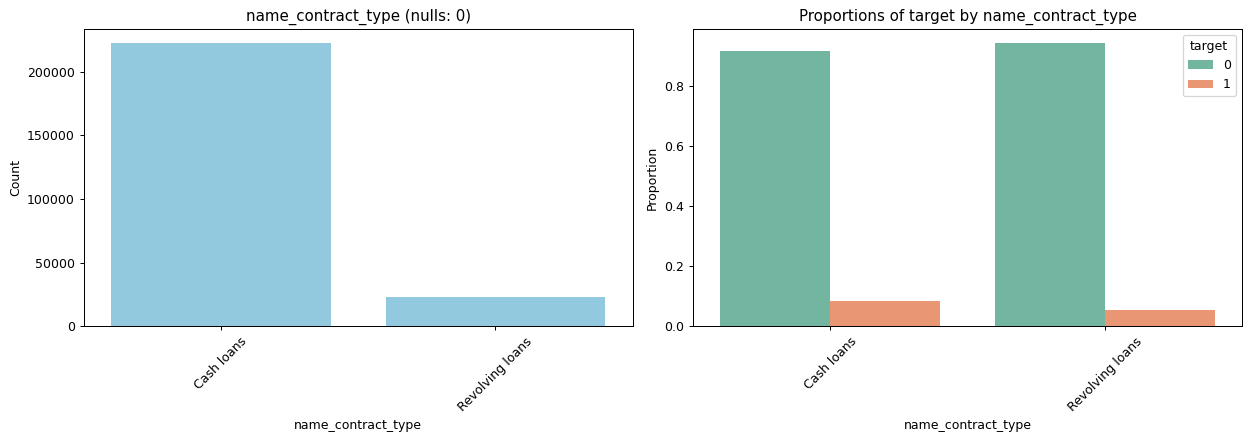

<ipython-input-23-ab79502d12a2>:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



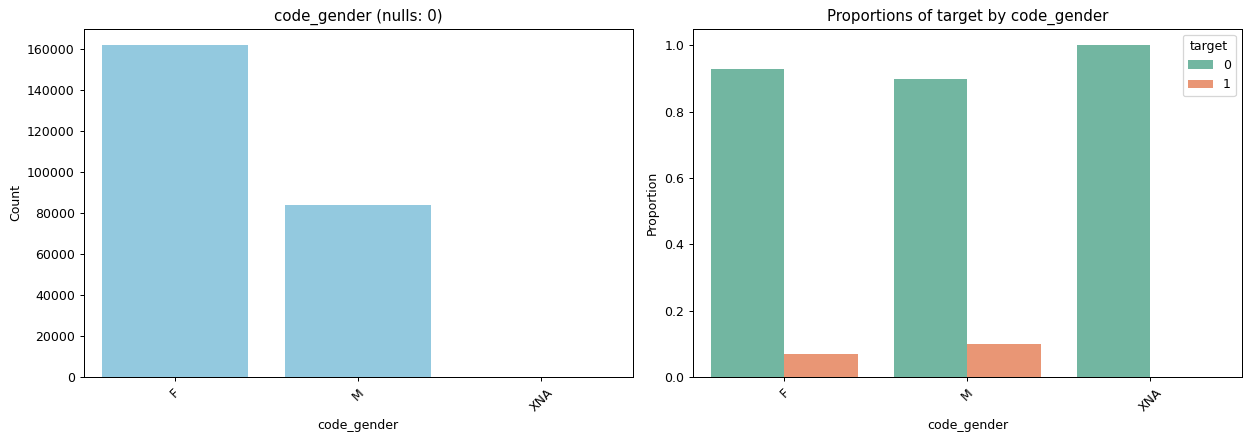

<ipython-input-23-ab79502d12a2>:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



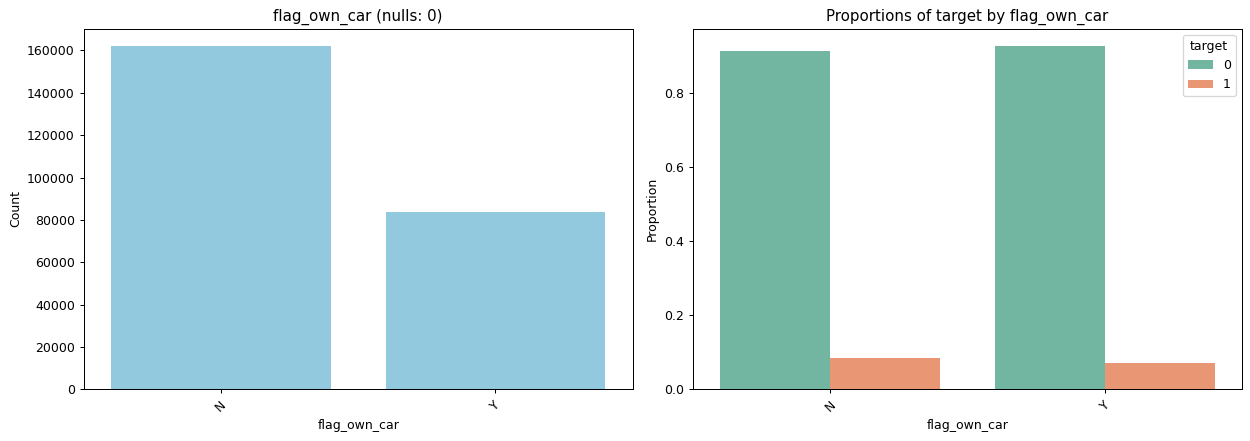

<ipython-input-23-ab79502d12a2>:72: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



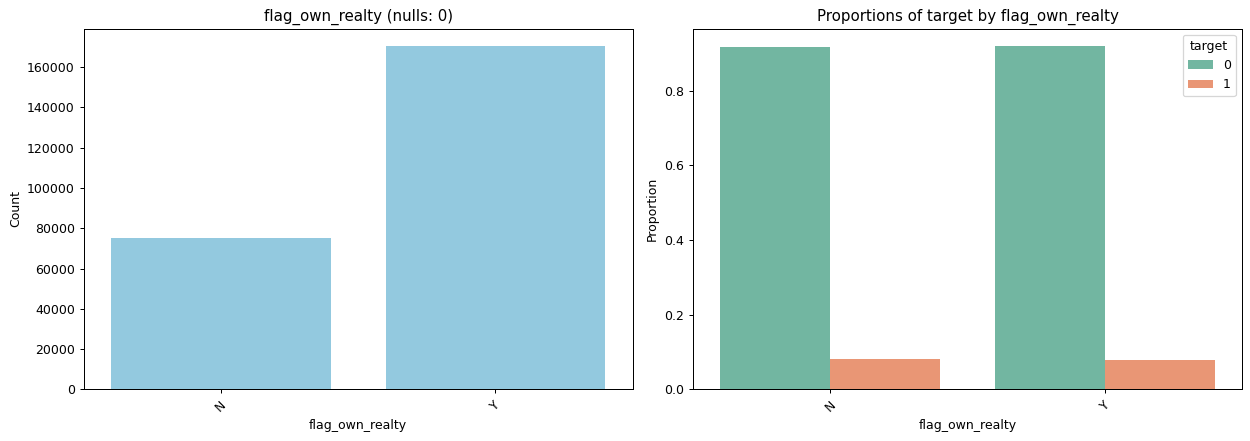

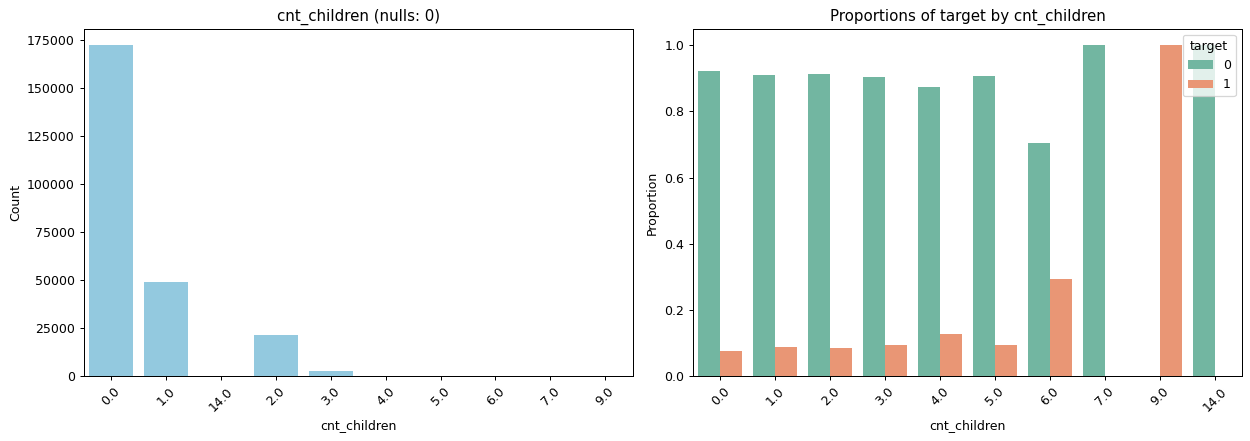

In [25]:
def plot_features_by_type_limited(df, target, plot_func, max_continuous=5, max_categorical=5):
    """
    Iterates through a limited number of columns in the DataFrame, identifies the type of variable,
    and applies the appropriate plot function.

    Parameters:
    - df: pd.DataFrame
      The input DataFrame.
    - target: str
      Name of the target variable.
    - plot_func: function
      Function to call for plotting, accepting arguments (df, col_name, isContinuous, target).
    - max_continuous: int
      Maximum number of continuous variables to plot.
    - max_categorical: int
      Maximum number of categorical variables to plot.
    """
    continuous_cols = []
    categorical_cols = []

    # Classify columns as continuous or categorical
    for col in df.columns:
        if col == target:
            continue  # Skip the target column

        if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 20:
            continuous_cols.append(col)
        else:
            categorical_cols.append(col)

    # Select a subset of columns to plot
    selected_continuous = continuous_cols[:max_continuous]
    selected_categorical = categorical_cols[:max_categorical]

    # Plot the selected columns
    for col in selected_continuous:
        plot_func(df, col_name=col, isContinuous=True, target=target)

    for col in selected_categorical:
        plot_func(df, col_name=col, isContinuous=False, target=target)


# Example usage with your DataFrame and plotting function
plot_features_by_type_limited(
    credit_processed_train,
    target='target',
    plot_func=plot_feature_variable,
    max_continuous=5,
    max_categorical=5
)


A thorough analysis of various graphs depicting different variables and their relationship to the target has been carried out. The main findings are:

- **Documentation:** Most applicants do not submit many additional documents (`flag_document_X`). Those who submit fewer documents tend to have a higher probability of reaching target 0.
Contact information: Most applicants do not have a registered phone (`flag_phone`) or email (`flag_email`). This does not seem to have a significant influence on the target.
- **Occupation:** The most common occupation is "Unspecified" and most occupation types have a higher proportion of target 0.
Family: The most common number of family members is 2 and most families live in apartments or houses.
Region: Most applicants reside in regions with a score of 2.0, and this score does not seem to have a significant influence on the target.
Others: Variables such as car age, family size, and region rating do not show a clear relationship with the goal.

Most applicants share similar characteristics: They do not present many additional documents, have no registered phone or email, and reside in regions with an average rating.

Goal 0 is most common: Regardless of the variable analyzed, most applicants tend to achieve goal 0.

No clear relationships observed: With the exception of documentation, no clear and direct relationships have been found between the variables analyzed and the goal.

Goal 0 is the most likely outcome: Based on the data analyzed, it seems that goal 0 is the most common and expected outcome.

Documentation could be a factor to consider: The lack of additional documentation could be related to a lower probability of achieving goal 1.

This code is designed to visualize variables within a dataset, both continuous and categorical, and allows us to explore the relationship of these variables with a target variable `target`.

The code runs by iterating over all columns of the dataset. If the column is continuous and is not the target variable `target`, it calls the function `plot_feature` with `isContinuous=True`. If the column is categorical (or not continuous), it calls the same function with `isContinuous=False`.

This code is useful for data exploration and visualization, allowing us to conduct a preliminary analysis of both continuous and categorical variables.

The generated plots help us understand the distribution of the data and the relationship of each variable with the target variable. For example, the first plot for `SK_ID_CURR` shows the distribution of the `SK_ID_CURR` variable, which appears to be a unique identifier for each client, along with a boxplot that compares the distribution of this variable in relation to the target variable `target`.

In conclusion, this code has allowed us to visualize the distribution of an identifier variable like `SK_ID_CURR` to ensure there are no obvious errors in the data (such as missing or outlier values), and also confirm that the identifier variable is not related to the behavior of the target variable `target`, indicating that it is not relevant for predictive analysis.


## **Handling Continuous Variables**

Next, we will address the missing values, correlations of continuous variables, and outliers.

1. **Missing Values**: We will check for missing values in the continuous variables and apply appropriate strategies for imputation or removal.

2. **Correlations**: We will analyze the correlations between the continuous variables to understand their relationships and potential multicollinearity issues.

3. **Outliers**: We will identify outliers in the continuous variables using methods like the Interquartile Range (IQR) or Z-scores and decide how to handle them, either by capping, removing, or transforming them.

These steps will ensure that the continuous variables are properly prepared for modeling, minimizing any potential issues that could affect the performance of the machine learning algorithms.


In [34]:
list_var_continuous
print(list_var_continuous[:10])

['sk_id_curr', 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative', 'days_birth', 'days_employed', 'days_registration', 'days_id_publish']


### **Handling Outliers**

Outliers are extreme values that can distort the analysis and model performance. The treatment of outliers involves identifying and managing these extreme values to ensure that they do not negatively affect the model.

Steps to handle outliers:
1. **Identification**:
   - We will detect outliers using methods such as the Interquartile Range (IQR) or Z-scores.
   - Outliers are typically defined as values that fall below the first quartile (Q1) minus 1.5 times the IQR, or above the third quartile (Q3) plus 1.5 times the IQR.
   
2. **Handling Outliers**:
   - **Removal**: In some cases, outliers may be removed if they represent erroneous data or have no meaningful impact.
   - **Capping**: Alternatively, outliers can be capped at a certain threshold to minimize their impact without removing them.
   - **Transformation**: Applying transformations like logarithms or square roots to reduce the influence of extreme values.

By addressing the outliers appropriately, we ensure that the model is not unduly influenced by extreme values, leading to better model performance and more reliable predictions.


In [36]:
# Function to detect outliers using the interquartile range (IQR)
def detect_outliers_iqr(data, variables, multiplier=3):
    outlier_dict = {}
    for var in variables:
        Q1 = data[var].quantile(0.25)
        Q3 = data[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        outliers = data[(data[var] < lower_bound) | (data[var] > upper_bound)]
        outlier_dict[var] = len(outliers)
    return pd.DataFrame({'Variable': variables, 'Outlier_Count': [outlier_dict[v] for v in variables]})

outlier_results = detect_outliers_iqr(credit_processed_train, list_var_continuous, multiplier=3)
print(outlier_results.head(10))

# Save the results
outlier_results.to_csv("outlier_analysis_results.csv", index=False)

                     Variable  Outlier_Count
0                  sk_id_curr              0
1            amt_income_total           2423
2                  amt_credit            343
3                 amt_annuity            816
4             amt_goods_price            864
5  region_population_relative              0
6                  days_birth              0
7               days_employed          47773
8           days_registration              1
9             days_id_publish              0


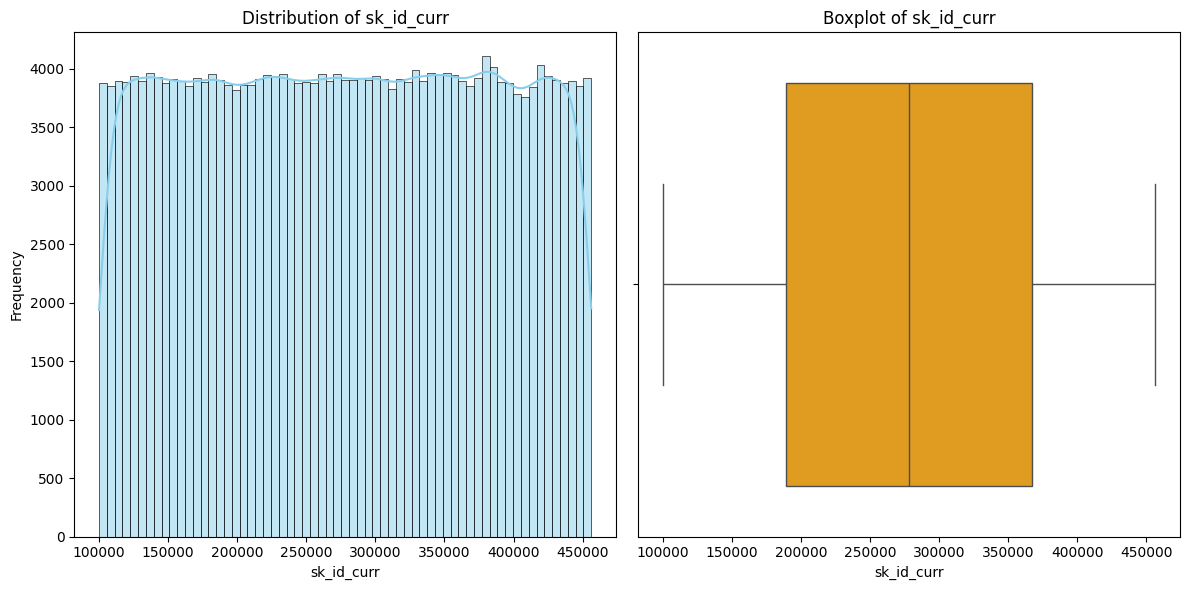

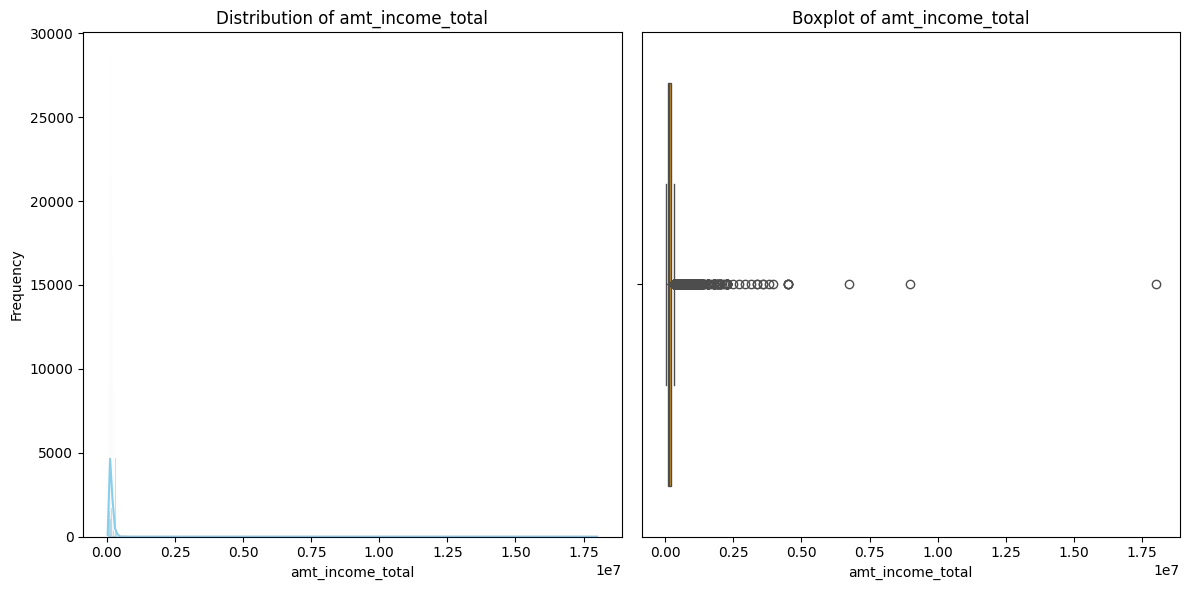

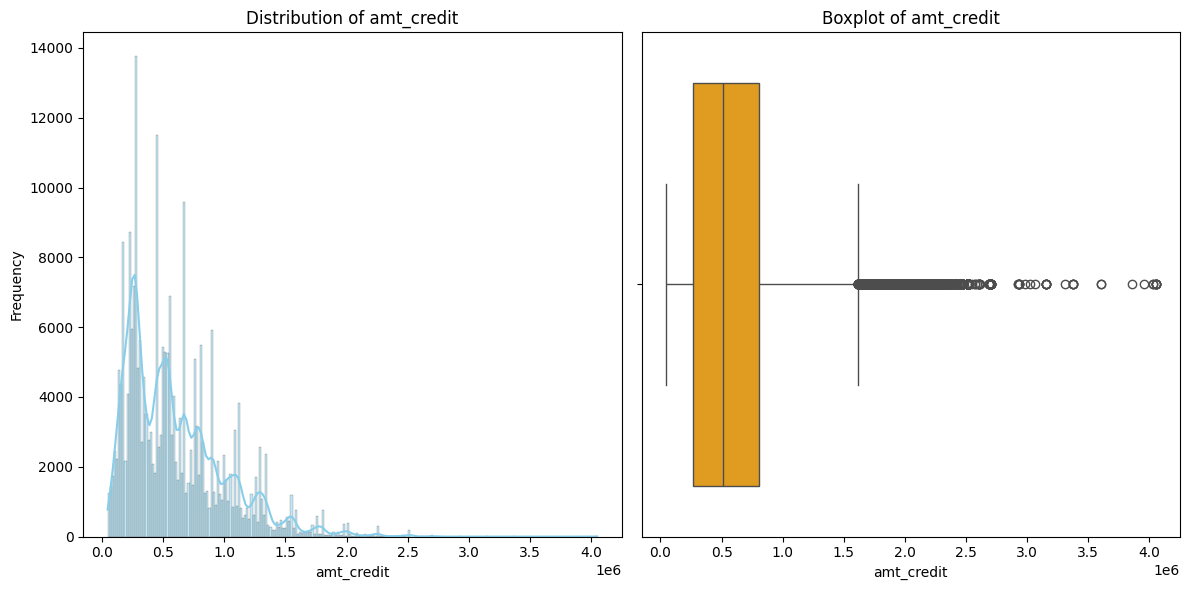

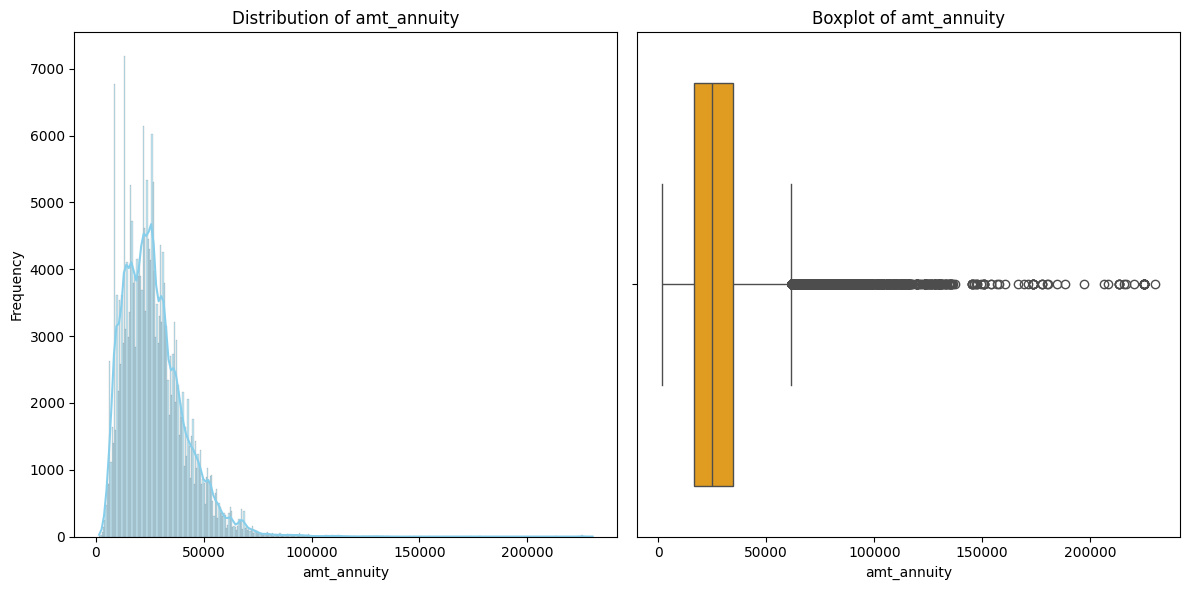

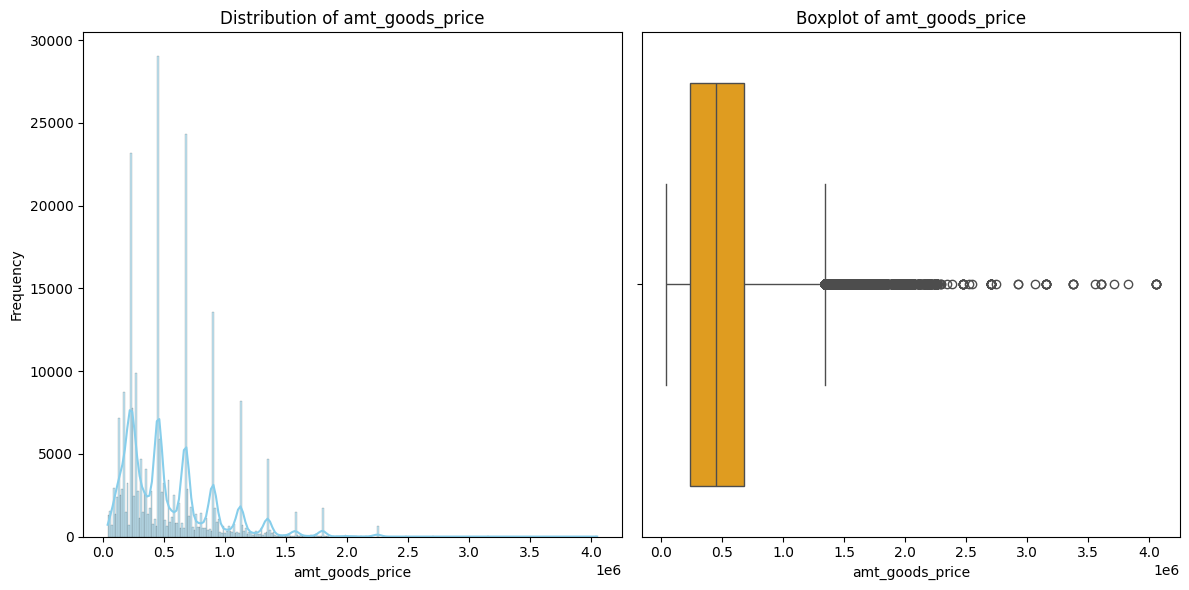

In [40]:
subset_vars = list_var_continuous[:5]

for var in subset_vars:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(credit_processed_train[var], kde=True, color='skyblue')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=credit_processed_train[var], color='orange')
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)

    plt.tight_layout()
    plt.show()

Now we can visually analyze the distributions of the continuous variables and the identified outliers to decide whether to remove them or handle them in some other way.

Common Trends:

- **Right skew:** Many numeric variables (such as `amt_goods_price`, `amt_credit`, `days_registration`, etc.) exhibit a right-skewed distribution. This indicates that most values ​​are concentrated at the bottom of the range, with some extremely high values.

- **Outliers:** Outliers have been identified for several variables, especially those with skewed distributions. These outliers can significantly influence statistical calculations and models.

- **Normal (approximate) distribution:** Some variables, such as days_birth and days_id_publish, exhibit an approximately normal distribution, indicating that values ​​are relatively evenly distributed around the mean.
Interpretation of Variables:

- **Monetary variables (`amt_goods_price`, `amt_credit`, `amt_annuity`):** These variables typically have right-skewed distributions, suggesting that most loans are for relatively small amounts, but there are some loans for much higher amounts.

- **Time variables (`days_birth`, `days_registration`, `days_id_publish`):** These variables typically have skewed or bimodal distributions, reflecting different patterns in the data. For example, days_registration may show a peak at values ​​close to zero, indicating that many loans were registered recently.

- **Categorical variables (`flag_document_X`, `occupation_type`, etc.):** These variables typically have discrete distributions, with a limited number of possible values. The distribution of these variables can reveal patterns in the composition of the sample.

Analyzing the distributions of variables provides a solid basis for understanding the data and selecting appropriate analysis techniques. By identifying key features of distributions, we can make informed decisions about how to preprocess the data and build predictive models.

In [42]:
df_processed_median = treat_outliers(credit_processed_train.copy(), list_var_continuous, method="median")
df_processed_mean = treat_outliers(credit_processed_train.copy(), list_var_continuous, method="mean")

print("Data processed with median (subset):")
print(df_processed_median[subset_vars].head())

print("\nData processed with mean (subset):")
print(df_processed_mean[subset_vars].head())

Data processed with median (subset):
        sk_id_curr  amt_income_total  amt_credit  amt_annuity  amt_goods_price
79791     192498.0          135000.0    983160.0      62964.0         900000.0
96354     211859.0          225000.0    755190.0      32125.5         675000.0
39321     145537.0          157500.0    343800.0      16852.5         225000.0
231917    368625.0          112500.0    945000.0      31360.5         945000.0
49579     157394.0          180000.0    495000.0      24750.0         495000.0

Data processed with mean (subset):
        sk_id_curr  amt_income_total  amt_credit  amt_annuity  amt_goods_price
79791     192498.0          135000.0    983160.0      62964.0         900000.0
96354     211859.0          225000.0    755190.0      32125.5         675000.0
39321     145537.0          157500.0    343800.0      16852.5         225000.0
231917    368625.0          112500.0    945000.0      31360.5         945000.0
49579     157394.0          180000.0    495000.0      2475

Our analysis begins with the **identification of outliers** through statistical analysis using the Interquartile Range (IQR). Then, to visualize these outliers and gain a better understanding of their distribution, we use **distribution plots**. Finally, once the outliers are identified and visualized, we perform **outlier treatment**, where the outliers are replaced by either the **median** or the **mean** depending on the chosen method. This allows for better data quality before feeding the data into the predictive model. This sequential and detailed approach ensures that outliers are properly handled to optimize model performance without losing valuable information.

After this analysis, we observed the following:

1. **Variables without outliers (Outlier Count = 0)**:
   - SK_ID_CURR, REGION_POPULATION_RELATIVE, DAYS_BIRTH, HOUR_APPR_PROCESS_START, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, among others.

   These variables appear to have more controlled distributions, probably with well-defined limits or no significant extreme values. This could be due to these features being kept within a reasonable range due to the nature of the data (e.g., limited scales like percentages or time ranges).

2. **Variables with moderate outliers (Outlier Count between 100 and 4000)**:
   - CNT_CHILDREN, AMT_CREDIT, AMT_ANNUITY, CNT_FAM_MEMBERS, OWN_CAR_AGE, among others.

   These variables show some dispersion in the data, probably reflecting unusual but plausible cases.

   For example: In `CNT_CHILDREN`, the extreme values might represent families with a significantly high number of children.

   `OWN_CAR_AGE` could have outliers related to very old car records or data entry errors.

3. **Variables with many outliers (Outlier Count > 10,000)**:
   - DAYS_EMPLOYED, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, etc.

   These variables present a considerable amount of extreme values. Some possible reasons include:

   - `DAYS_EMPLOYED`: It may contain invalid records (such as extremely high values for people who have never worked).


 AMT_REQ_CREDIT_BUREAU_*: It could be influenced by errors in the recording of credit inquiries or outlier cases of individuals with high credit activity.


### **Correlations**

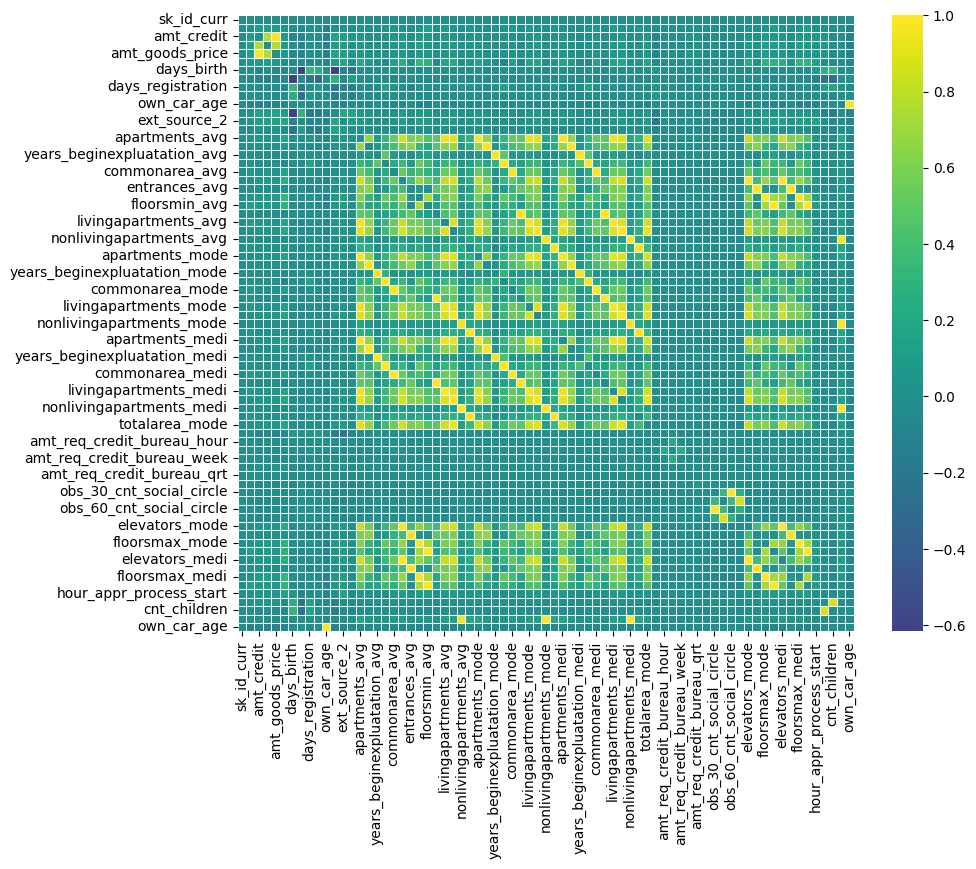

In [ ]:
# Correlation Matrix for Numerical Variables
num_corr_matrix = get_corr_matrix(dataset=credit_processed_train[list_var_continuous], method='pearson', size_figure=[10, 8])

In this matrix, each cell represents the correlation coefficient between two different numerical variables. The correlation coefficients are color-coded:

- **Yellow:** Indicates a strong positive correlation (values ​​close to 1).

- **Dark blue:** Indicates a strong negative correlation (values ​​close to -1).

- **Green:** Indicates little or no correlation (values ​​close to 0).

Some key observations:
- **`amt_credit` and `amt_goods_price`:** There is a strong positive correlation between these two variables. This suggests that as the amount of credit (`amt_credit`) increases, so does the price of goods (`amt_goods_price`).

- **`ext_source_2`:** This variable shows a significant negative correlation with `days_birth`, indicating that scores from this external source tend to be higher for younger people.

- **`amt_req_credit_bureau_hour`, `amt_req_credit_bureau_week`, and `amt_req_credit_bureau_qrt`:** These variables have a notable positive correlation with each other, which is expected since they all refer to the frequency of credit requests to the bureau.

### **Handling Missing Values**

Are all missing values associated with a specific class of the target variable? Or do they have the same percentage across the target variable?

In this step, we will calculate the percentage of present values in each numerical variable. Additionally, we will analyze the distribution of missing values for each unique value of the target variable (`TARGET`). This analysis is crucial as it will help us identify if there is a significant difference in the proportion of missing values between the two classes of the target variable (0 and 1).

If we find that a column shows a significant difference in the proportion of missing values between the two classes of `TARGET`, it could suggest that the column is relevant for analysis. Missing values in that column might be associated with a specific class of the target. For example, if missing values are concentrated more in the cases where `TARGET = 1`, it might indicate a pattern that is useful for predicting the target variable.

On the other hand, if we don't find a significant difference, we may conclude that the missing values in that column do not have a considerable impact on predicting `TARGET`. In this case, we could decide not to give much importance to these missing values or, if the proportion of missing values is too high, even consider removing the column from the analysis.

In addition to the missing values, we will calculate the relationship between the numerical variables and the target variable (`TARGET`). This will help us identify which variables have a strong correlation or significant relationship with the target, which is key to deciding how to handle them. If a variable shows a strong relationship with `TARGET`, it might be relevant for the model, and we should be cautious when handling missing values or any other type of missing data in that variable.

This evaluation will allow us to make informed decisions on how to handle columns with missing values: whether we should remove them, impute them with suitable values, or treat them differently based on their impact on the analysis.


In [43]:
subset_df = credit_processed_train[subset_vars + ['target']]
calculate_nulls_by_objective(subset_df, 'target', 'continuous')

<ipython-input-23-ab79502d12a2>:224: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Target_0,Target_1,Total_Percentage (%),Difference_0_1 (%)
amt_goods_price,0.08,0.08,0.08,0.0
sk_id_curr,0.00,0.00,0.00,0.0
amt_income_total,0.00,0.00,0.00,0.0
amt_credit,0.00,0.00,0.00,0.0
amt_annuity,0.00,0.00,0.00,0.0


In [44]:
corr_with_target = credit_processed_train[list_var_continuous].corrwith(credit_processed_train['target'], method='pearson')
print(corr_with_target.head())

sk_id_curr         -0.002925
amt_income_total   -0.021229
amt_credit         -0.031073
amt_annuity        -0.013582
amt_goods_price    -0.040359
dtype: float64


In [ ]:
# Metric for Handling Missing Values
low_correlation_threshold = 0.1
high_correlation_threshold = 0.5
null_threshold = 0.7

# Calculate the percentage of null values in the columns
percentage_nulls = credit_processed_train.isnull().mean()

# Iterate over numeric columns
for col in list_var_continuous:
    # Get the correlation of the column with the target (this is a scalar value now)
    col_corr = corr_with_target.get(col, None)  # Si no existe, retorna None

    if col_corr is not None:  # Verificar si la columna tiene una correlación con el objetivo
        # Condition 1: If the Column Has Low Correlation and Many Nulls
        if isinstance(col_corr, (float, int)) and col_corr < low_correlation_threshold and percentage_nulls[col] > null_threshold:
            credit_processed_train[col] = credit_processed_train[col].fillna(credit_processed_train[col].median())

        # Condition 2: If the Column Has High Correlation with the Target
        elif isinstance(col_corr, (float, int)) and col_corr > high_correlation_threshold:
            credit_processed_train[col] = credit_processed_train[col].fillna(credit_processed_train[col].median())

        # Condition 3: If the Column Has Missing Values Unevenly Distributed Across the Target Classes
        elif percentage_nulls[col] > 0:
            for target_class in credit_processed_train['target'].unique():
                median_class = credit_processed_train[credit_processed_train['target'] == target_class][col].median()
                credit_processed_train.loc[(credit_processed_train['target'] == target_class) & (credit_processed_train[col].isnull()), col] = median_class

# Delete columns with more than 70% nulls and low threshold
columns_to_delete = [
    col for col in list_var_continuous
    if percentage_nulls[col] > null_threshold and isinstance(corr_with_target.get(col, None), (float, int)) and corr_with_target.get(col, None) < low_correlation_threshold
]
credit_processed_train = credit_processed_train.drop(columns=columns_to_delete)



### 1. Handling Missing Values with the Median

- **Low Correlation and High Missing Values**: We impute the median only for columns with low correlation to the target variable and a high percentage of missing values.
  
- **High Correlation**: If the correlation with the target variable is high, we also impute the median to retain valuable information for the model.

- **Uneven Distribution of Missing Values**: If the missing values are unevenly distributed according to the target variable classes, we impute the median by class. This ensures that the imputation respects the distribution of the target variable.

### 2. Column Removal

- **High Missing Values and Low Correlation**: If a column has more than 70% missing values and low correlation with the target variable, we remove it from the DataFrame. This helps in eliminating columns that are not contributing meaningful information to the model.



In [ ]:
# Imputation of Missing Values with the Median for the Training Set Columns
#In this step, we will handle missing values by imputing them with the median of the respective columns in the training set.

medians_train = credit_processed_train[list_var_continuous].median()

# Filtrar las columnas de tipo float
columns_float = credit_processed_test.select_dtypes(include='float').columns

# Llenar los valores nulos solo en las columnas de tipo float usando las medianas de medianas_train
credit_processed_test[columns_float] = credit_processed_test[columns_float].fillna(medians_train[columns_float])

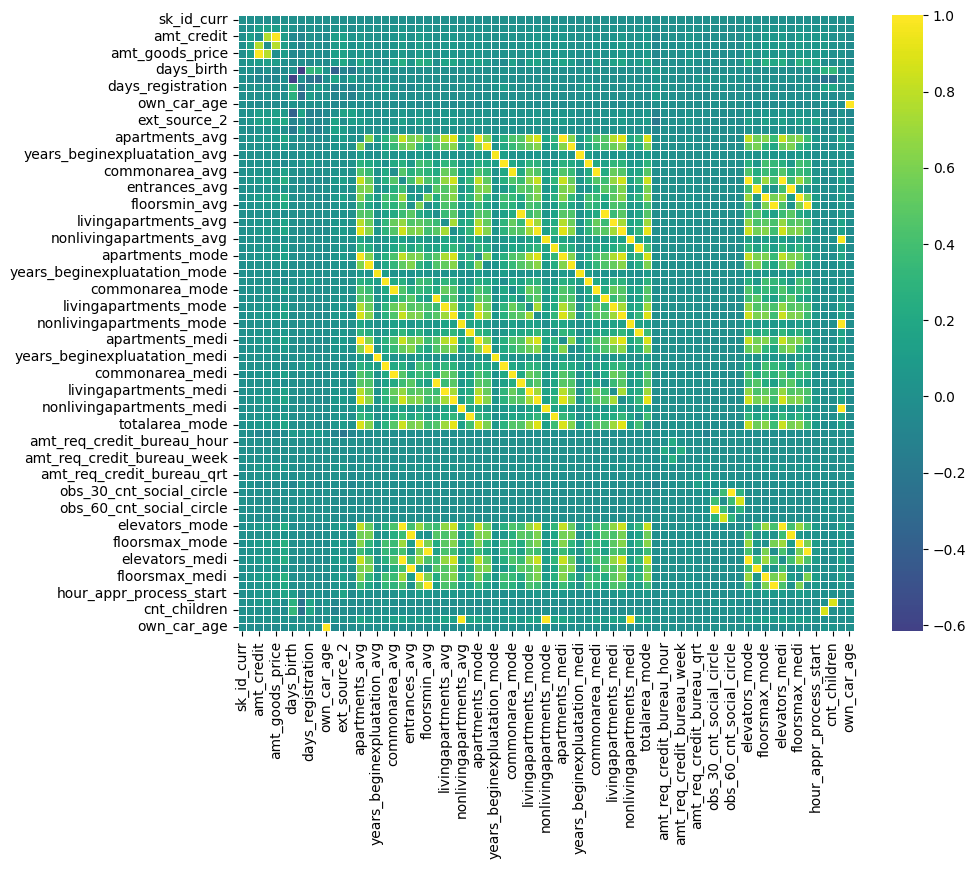

In [ ]:
num_corr_matrix_without_nulls = get_corr_matrix(dataset=credit_processed_train[list_var_continuous], method='pearson', size_figure=[10, 8])

Strong positive correlation:

- `years_beginexpluatation_avg` and `years_beginexpluatation_med` show a strong positive correlation, suggesting that these variables are closely related.

- `livingapartments_avg` and `livingapartments_medi` are also highly positively correlated, indicating that these two measures are very similar.

Negative correlation:

- `days_birth` and `ext_source_2` have a significant negative correlation. This indicates that higher values ​​of `ext_source_2` tend to be associated with younger people.

Little or no correlation:

- Some variables such as `sk_id_curr` do not show a strong correlation with other variables, which can be useful for identifying independent variables in further analysis.

## **Handling Categorical Variables**

Handling categorical variables is an essential step in the data preprocessing pipeline, especially when preparing data for machine learning models.


### **Correlations**

In [48]:
warnings.filterwarnings('ignore')

correlation_matrix = pd.DataFrame(index=list_var_cat, columns=list_var_cat)

for var1 in list_var_cat:
    for var2 in list_var_cat:
        if var1 != var2:
            confusion_matrix = pd.crosstab(credit_processed_train[var1], credit_processed_train[var2])
            if confusion_matrix.shape[0] > 1 and confusion_matrix.shape[1] > 1:
                cramers_v_value = cramers_v(confusion_matrix.values)
                correlation_matrix.loc[var1, var2] = cramers_v_value
            else:
                correlation_matrix.loc[var1, var2] = np.nan
        else:
            correlation_matrix.loc[var1, var2] = 1.0

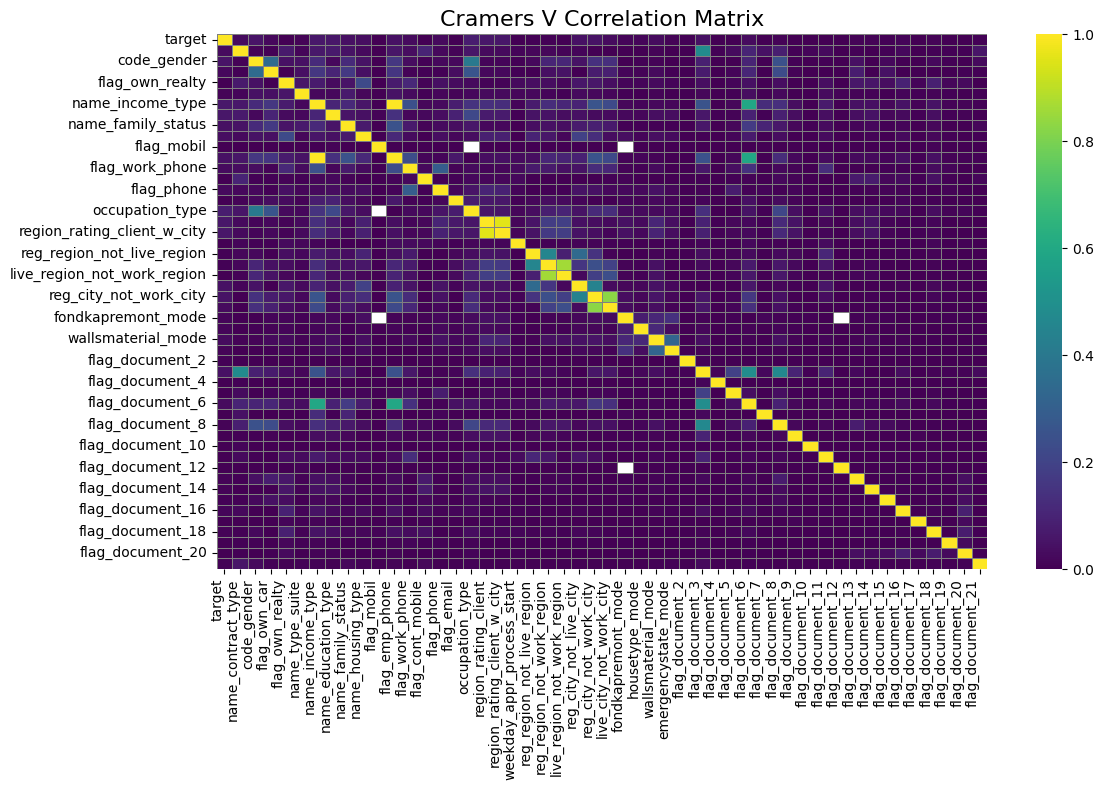

In [49]:
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=False, cmap="viridis", vmin=0, vmax=1, cbar=True, linewidths=0.5, linecolor='gray')

plt.title('Cramers V Correlation Matrix', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

Strong Correlations:

- The main diagonal of the matrix is ​​yellow, indicating a perfect correlation (value of 1.0) of each variable with itself, as expected.

- We notice several cells in yellow tones off the diagonal, indicating a strong positive correlation between different categorical variables. For example, variables like `code_gender` and `flag_own_realty` may have a high correlation if a specific gender tends to own more real estate.

Low or Negative Correlations:

- Cells colored purple indicate low or no correlations between categorical variables. This can be useful for identifying variables that do not directly influence each other and could provide unique information in a predictive model.

### **Handling Missing Values**

In [45]:
categorical_vars = [col for col in credit_processed_train.columns if col != 'target' and not pd.api.types.is_numeric_dtype(credit_processed_train[col])]
subset_categorical_vars = categorical_vars[:5]
subset_df = credit_processed_train[subset_categorical_vars + ['target']]
calculate_nulls_by_objective(subset_df, 'target', 'categorical')

<ipython-input-23-ab79502d12a2>:224: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Target_0,Target_1,Total_Percentage (%),Difference_0_1 (%)
name_type_suite,0.42,0.26,0.34,-0.16
target,0.00,0.00,0.00,0.00
name_contract_type,0.00,0.00,0.00,0.00
code_gender,0.00,0.00,0.00,0.00
flag_own_car,0.00,0.00,0.00,0.00
flag_own_realty,0.00,0.00,0.00,0.00


In [50]:
correlation_with_target = correlation_matrix['target'].sort_values(ascending=False)
correlation_with_target.head()

,target
target,1.000000
occupation_type,0.080682
name_income_type,0.062737
region_rating_client_w_city,0.060838
region_rating_client,0.058698


In [ ]:
boolean_columns = [
    col for col in list_var_cat
    if set(credit_processed_train[col].dropna().unique()).issubset({0, 1})
]

non_boolean_columns = [col for col in list_var_cat if col not in boolean_columns]

for col in non_boolean_columns:
    if credit_processed_train[col].dtype.name == 'category':
        credit_processed_train[col] = credit_processed_train[col].cat.add_categories('Unspecified')

credit_processed_train[non_boolean_columns] = credit_processed_train[non_boolean_columns].fillna("Unspecified")



In this case, we have decided to replace all missing values with "No Especificado" because the proportion of missing values in the variables is low and will not significantly affect the overall distribution of the data. Additionally, many of these variables are relevant for predicting the target variable (`target`), so keeping the records with this category ensures that valuable information is not lost.

In [ ]:
# Imputation of Missing Values (NaN) in Categorical Columns of the Test Dataset (data_test)

boolean_columns = [
    col for col in list_var_cat
    if set(credit_processed_test[col].dropna().unique()).issubset({0, 1})
]

non_boolean_columns = [col for col in list_var_cat if col not in boolean_columns]

for col in non_boolean_columns:
    if credit_processed_test[col].dtype.name == 'category':
        credit_processed_test[col] = credit_processed_test[col].cat.add_categories('Unspecified')

credit_processed_test[non_boolean_columns] = credit_processed_test[non_boolean_columns].fillna("Unspecified")

In [ ]:
credit_processed_train.to_csv(r'../content/credit_processed_train.csv', index=False)

In [ ]:
credit_processed_test.to_csv(r'../content/credit_processed_test.csv', index=False)

In this notebook, we conducted a comprehensive analysis of the dataset to prepare the data for robust predictive modeling. The primary tasks involved handling missing values, detecting and addressing outliers, and exploring correlations between variables.

We began by classifying the variables into continuous and categorical types, carefully considering their nature and context. For continuous variables with missing values, we used median imputation, particularly when these variables showed strong correlations with the target variable (target). For categorical variables, missing values were replaced with the "Not Specified" category, ensuring that no useful information was lost.

Outliers in continuous variables were detected using the interquartile range (IQR) method. These outliers were treated by replacing them with the median or mean, depending on the situation. Some variables, such as days_employed, contained a significant number of outliers, which we handled appropriately, while others, like days_birth, had distributions that were well-controlled and free of significant outliers.

We also explored correlations between variables. For continuous variables, we used Pearson’s correlation coefficient, while for categorical variables, we calculated Cramér's V to assess the strength of relationships. This analysis revealed meaningful patterns, such as a strong correlation between amt_credit and amt_goods_price, suggesting that higher credit amounts tend to be associated with more expensive goods.

Finally, the dataset was divided into training and test sets using stratified sampling. This ensures that both sets contain a proportional representation of the target variable, helping to avoid bias in model evaluation.

In conclusion, the dataset is now well-prepared for modeling. We have addressed missing values and outliers, identified key correlations, and structured the data for the next steps in predictive modeling. This preparation ensures that the data is of high quality, providing a solid foundation for building accurate and reliable models.